<a href="https://colab.research.google.com/github/nima-abdpoor/snapfood_satisfaction/blob/main/SnapFood_Satisfaction_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras import regularizers
from keras.layers import Embedding
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import io
from google.colab import files
import gensim
from gensim.models.word2vec import Word2Vec
#!pip install hazm
#!pip install tensorflow
from hazm import word_tokenize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,Bidirectional, SpatialDropout1D
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
import keras
from keras.initializers import Constant
from keras.layers import ReLU
from keras.layers import Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report




In [ ]:
#  tfds.disable_progress_bar()


In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

#Setup input pipeline

In [ ]:
# dataset, info = tfds.load('imdb_reviews', with_info=True,
#                           as_supervised=True )
# train_dataset, test_dataset = dataset['train'], dataset['test']

# train_dataset.element_spec

In [ ]:
uploaded = files.upload()


Saving dev.csv to dev.csv
Saving train.csv to train.csv


In [ ]:
train = pd.read_csv(io.BytesIO(uploaded['train.csv']),sep='\t')
dev = pd.read_csv(io.BytesIO(uploaded['dev.csv']), sep='\t')
train.comment = train.comment.astype('str')
train.label = train.label.astype('str')


In [ ]:
train

,Unnamed: 0,comment,label,label_id
0,0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1
1,1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0
2,2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1
3,3,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,HAPPY,0
4,4,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0
...,...,...,...,...
56695,56695,یک تیکه کم فرستاده بودن و با تماس من در کمترین...,HAPPY,0
56696,56696,عالی بود همه چیز ممنونم پیک هم خیلی مرتب و به ...,HAPPY,0
56697,56697,مثل همیشه عالی، من چندمین باره سفارش میدم و هر...,HAPPY,0
56698,56698,دلستر استوایی خواسته بودم اما لیمویی فرستادند,HAPPY,0


In [ ]:
dev

,Unnamed: 0,comment,label,label_id
0,0,همه ساندویچ‌ها سرد بود متاسفانه در صورتی که فا...,SAD,1
1,1,تشکر، عالی‌تر از همیشه,HAPPY,0
2,2,مرغ و کدو رو دوس نداشتم ولی کلا ساندویچهای خوش...,HAPPY,0
3,3,نمیدونم هزینه بسته بندی به چه دلیل گرفته شد؟؟؟,SAD,1
4,4,یک نوشابه کم ارسال شد و تاخیر فراوان و غذای نس...,SAD,1
...,...,...,...,...
6295,6295,سلام من به فاکتور غذاهایی که سفارش میدم احتیاج...,SAD,1
6296,6296,سایز پیتزا نسبت به سفارشاتی که قبلا گذشتم کم ش...,SAD,1
6297,6297,من قارچ اضافه رو اضافه کرده بودم بودم اما اگر ...,HAPPY,0
6298,6298,همرو بعد ۲ساعت تاخیر اشتباه آوردن پولشم رفت رو...,SAD,1


In [ ]:
labelencoder = LabelEncoder()
train['label'] = labelencoder.fit_transform(train['label'])

In [ ]:
train.comment = train.comment.astype('str')
train.label = train.label.astype('str')

In [ ]:
data = []
#Splitting pd.Series to list
data_to_list = train['comment'].values.tolist()
for i in range(len(data_to_list)):
    data.append(data_to_list[i])

print(data[:5])



['واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح', 'قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از موقع رسید، شما ببین چقدرررررررررررر پلاک خفنههههه، من سالهاست مشتریشونم و سالهاست مزه بهشت میده غذاشون', 'قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط ظاهر فریبنده داره، پرش میکنن کالباس و قارچ', 'عالللی بود همه چه درست و به اندازه و کیفیت خوب، امیداورم همیشه کیفیتتون خوب باشه ما مشتری همیشگی بشیم', 'شیرینی وانیلی فقط یک مدل بود.']


In [ ]:
# converting each sentence to list of words and inserting in sents
sents = [word_tokenize(comment) for comment in data]

# example
sents[45]

['کیک',
 'و',
 'جعبه',
 'ان',
 'متلاشی',
 'شده_بود',
 '.',
 'که',
 'پیک',
 'زمان',
 'تحویل',
 'گفت',
 'مقداری',
 'تکان',
 'خورده',
 'وقتی',
 'دیدم',
 'کیک',
 'رو',
 'خیلی',
 'بیشتر',
 'از',
 'یه',
 'کمی',
 'بو',
 'جالبه',
 'که',
 'حتی',
 'جعبه',
 'هم',
 'متلاشی',
 'شده_بود',
 '.',
 'اگر',
 'سرویس',
 'ارسال',
 'کیک',
 'رو',
 'پذیرفتید',
 'حداقل\u200cها',
 'رو',
 'هم',
 'رعایت',
 'کنید']

In [ ]:
model = Word2Vec(sentences=sents, size=64, window=10, min_count=5, seed=42, workers=5)

In [ ]:
model['غذا']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 0.25600109, -0.18726799,  0.60844135,  0.47548792, -0.924909  ,
       -1.0501778 ,  0.39773184,  0.39785036,  0.532589  ,  0.59718364,
        1.3899448 ,  1.9572335 , -0.14712936, -1.108402  , -2.6015432 ,
       -0.45899987,  0.2639696 ,  1.4904603 ,  1.8640258 , -0.26044357,
        1.3787675 ,  0.8451213 , -2.1743417 , -3.4696186 , -0.17362168,
       -2.0829206 , -0.23862043,  1.0610788 ,  0.7409633 , -1.3762344 ,
        2.0973537 , -0.61578107, -0.3031063 , -0.6237471 ,  0.5807381 ,
       -1.787867  ,  1.6538355 ,  2.9098244 ,  0.6465597 ,  4.756325  ,
        4.575757  ,  1.1960212 , -0.02444053,  1.2683488 ,  1.3766828 ,
       -0.7917383 ,  2.4490929 ,  2.2907927 , -0.7079356 ,  0.4888254 ,
       -0.7400853 , -0.07430378, -1.9016076 ,  2.7171822 ,  0.38755944,
       -0.726201  , -1.5448029 , -0.38742486,  0.3636171 ,  0.04405273,
        1.9685471 ,  1.8755355 ,  1.0708908 , -0.4427671 ], dtype=float32)

In [ ]:
# Let's check out most similar words to 'غذا'
model.most_similar('غذا', topn=15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('غدا', 0.6778163909912109),
 ('غذای', 0.6378273963928223),
 ('غذاها', 0.5602937936782837),
 ('غذا\u200cها', 0.5520271062850952),
 ('برنج', 0.5093979239463806),
 ('کباب', 0.4893389344215393),
 ('جوجه', 0.48535141348838806),
 ('رستوران', 0.4577800929546356),
 ('سرد', 0.4570837914943695),
 ('پیتزاها', 0.4419902563095093),
 ('مسافت', 0.43954306840896606),
 ('غذاش', 0.4330178499221802),
 ('سردی', 0.42220261693000793),
 ('شیشلیک', 0.4191654920578003),
 ('هوا', 0.4152989983558655)]

In [ ]:
# Another example
model.most_similar('عالی', topn=15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('لذیذ', 0.7823887467384338),
 ('عالى', 0.7786285877227783),
 ('خوشمزه', 0.7779120206832886),
 ('عاااالی', 0.7437888383865356),
 ('خوش', 0.7385042905807495),
 ('خوب', 0.7324227094650269),
 ('عالیه', 0.7046855688095093),
 ('باکیفیت', 0.664371132850647),
 ('خوشمزه\u200cای', 0.6386029124259949),
 ('مرسی', 0.6193557977676392),
 ('دلچسب', 0.6185131072998047),
 ('تمیز', 0.6183562278747559),
 ('عااالی', 0.6138214468955994),
 ('بینظیر', 0.6001291275024414),
 ('چسبید', 0.5911597013473511)]

In [ ]:
print(model.wv.vocab)

{'واقعا': <gensim.models.keyedvectors.Vocab object at 0x7f185105a510>, 'حیف': <gensim.models.keyedvectors.Vocab object at 0x7f185105a990>, 'وقت': <gensim.models.keyedvectors.Vocab object at 0x7f185105af10>, 'که': <gensim.models.keyedvectors.Vocab object at 0x7f185105a0d0>, 'بنویسم': <gensim.models.keyedvectors.Vocab object at 0x7f185105a090>, 'سرویس': <gensim.models.keyedvectors.Vocab object at 0x7f18510440d0>, 'دهیتون': <gensim.models.keyedvectors.Vocab object at 0x7f1851050d90>, 'شده': <gensim.models.keyedvectors.Vocab object at 0x7f18510506d0>, 'افتضاح': <gensim.models.keyedvectors.Vocab object at 0x7f185105a390>, 'قرار': <gensim.models.keyedvectors.Vocab object at 0x7f1851044150>, 'بود': <gensim.models.keyedvectors.Vocab object at 0x7f1851050710>, '۱': <gensim.models.keyedvectors.Vocab object at 0x7f1851050390>, 'ساعته': <gensim.models.keyedvectors.Vocab object at 0x7f1851050550>, 'برسه': <gensim.models.keyedvectors.Vocab object at 0x7f1851055490>, 'ولی': <gensim.models.keyedvector

In [ ]:
# total numberof extracted words.
vocab=model.wv.vocab
print("The total number of words are : ",len(vocab))

The total number of words are :  7416


In [ ]:
# print(vocab)
vocab=list(vocab.keys())

In [ ]:
word_vec_dict={}
for word in vocab:
  word_vec_dict[word]=model.wv.get_vector(word)
print("The no of key-value pairs : ",len(word_vec_dict)) # should come equal to vocab size

The no of key-value pairs :  7416


In [ ]:
tok = Tokenizer()
tok.fit_on_texts(train['comment'])
vocab_size = len(tok.word_index) + 1
encd_rev = tok.texts_to_sequences(train['comment'])

In [ ]:
for x in range(10):
  print(train['comment'].iloc[x])
  print(encd_rev[x])

واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح
[23, 442, 302, 5, 3603, 364, 4320, 14, 160]
قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از موقع رسید، شما ببین چقدرررررررررررر پلاک خفنههههه، من سالهاست مشتریشونم و سالهاست مزه بهشت میده غذاشون
[340, 1, 215, 1258, 366, 15, 191, 76, 420, 4, 93, 350, 115, 6740, 15059, 1419, 15060, 19, 3269, 7577, 2, 3269, 49, 6741, 556, 1203]
قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط ظاهر فریبنده داره، پرش میکنن کالباس و قارچ
[59, 17, 532, 25, 10, 239, 15061, 1886, 27, 705, 10915, 1522, 8845, 727, 434, 2, 161]
عالللی بود همه چه درست و به اندازه و کیفیت خوب، امیداورم همیشه کیفیتتون خوب باشه ما مشتری همیشگی بشیم
[6742, 1, 50, 291, 209, 2, 3, 205, 2, 9, 928, 15062, 35, 1198, 11, 98, 105, 104, 581, 4321]
شیرینی وانیلی فقط یک مدل بود.
[82, 1379, 27, 30, 532, 1]
بدترین پیتزایی که تا به حال خورده بودم
[352, 666, 5, 41, 3, 435, 269, 46]
از همه لحاظ عالی ممنونم
[4, 50, 567, 12, 122]
کیفیت غذا متوسط رو به پایین بود انگار داخل یه رستوران معمولی غذا خوردی درحالی که ا

In [ ]:
all_lens = []
for x in encd_rev:
  all_lens.append(len(x))
print(max(all_lens))

361


In [ ]:
max_rev_len = max(all_lens)  # max lenght of a comment
vocab_size = len(tok.word_index) + 1  # total no of words
embed_dim=64 # embedding dimension as choosen in word2vec constructor
print(vocab_size)

34165


In [ ]:
# now padding to have a amximum length of 361
pad_rev= pad_sequences(encd_rev, maxlen=max_rev_len, padding='post')
pad_rev.shape   # note that we had 100K reviews and we have padded each review to have  a lenght of 361 words.

(56700, 361)

In [ ]:
print(pad_rev)

[[  23  442  302 ...    0    0    0]
 [ 340    1  215 ...    0    0    0]
 [  59   17  532 ...    0    0    0]
 ...
 [  51   35  413 ...    0    0    0]
 [ 760 2453  601 ...    0    0    0]
 [ 120   34  832 ...    0    0    0]]


In [ ]:
# # now creating the embedding matrix
# embed_matrix=np.zeros(shape=(vocab_size,embed_dim))
# for word,i in tok.word_index.items():
#   embed_vector=word_vec_dict.get(word)
#   if embed_vector is not None:  # word is in the vocabulary learned by the w2v model
#     embed_matrix[i]=embed_vector
#   # if word is not found then embed_vector corressponding to that vector will stay zero.

In [ ]:
# # checking.
# print(len(embed_matrix))
# print(embed_matrix[14])

In [ ]:
# prepare train and val sets first
Y= to_categorical(train['label'])    # one hot target as required by NN.
x_train,x_test,y_train,y_test=train_test_split(pad_rev,Y,test_size=0.30,random_state=42)

In [ ]:
model = Sequential()
# model.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=max_rev_len,embeddings_initializer=Constant(embed_matrix)))
model.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=max_rev_len))
model(pad_rev)
# model.add(CuDNNLSTM(64,return_sequences=False)) # loss stucks at about 
model.add(Bidirectional(tf.keras.layers.LSTM(64)))
model.add(Dense(16,activation='relu'))
model.add(Dropout(0.50))
# model.add(Dense(16,activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(2,activation='sigmoid'))  # sigmod for bin. classification.

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 361, 64)           2186560   
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 16)                2064      
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_9 (Dense)             (None, 2)                 34        
                                                                 
Total params: 2,254,706
Trainable params: 2,254,706
Non-trainable params: 0
____________________________________________

In [ ]:
# compile the model
model.compile(optimizer=optimizers.RMSprop(lr=1e-3),loss='binary_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
# specify batch size and epocj=hs for training.
epochs=10
batch_size=64

In [ ]:
  # fitting the model.
history = model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data=(x_test,y_test))

Epoch 1/10
621/621 [==============================] - 406s 648ms/step - loss: 0.4556 - accuracy: 0.8155 - val_loss: 0.3478 - val_accuracy: 0.8496
Epoch 2/10
621/621 [==============================] - 382s 615ms/step - loss: 0.3519 - accuracy: 0.8616 - val_loss: 0.3382 - val_accuracy: 0.8540
Epoch 3/10
621/621 [==============================] - 371s 598ms/step - loss: 0.3326 - accuracy: 0.8688 - val_loss: 0.3483 - val_accuracy: 0.8503
Epoch 4/10
621/621 [==============================] - 380s 611ms/step - loss: 0.3169 - accuracy: 0.8743 - val_loss: 0.3622 - val_accuracy: 0.8529
Epoch 5/10
621/621 [==============================] - 377s 607ms/step - loss: 0.3054 - accuracy: 0.8793 - val_loss: 0.3372 - val_accuracy: 0.8573
Epoch 6/10
621/621 [==============================] - 370s 596ms/step - loss: 0.2914 - accuracy: 0.8844 - val_loss: 0.3715 - val_accuracy: 0.8508
Epoch 7/10
621/621 [==============================] - 378s 608ms/step - loss: 0.2798 - accuracy: 0.8907 - val_loss: 0.3672 -

(0.0, 0.466353427618742)

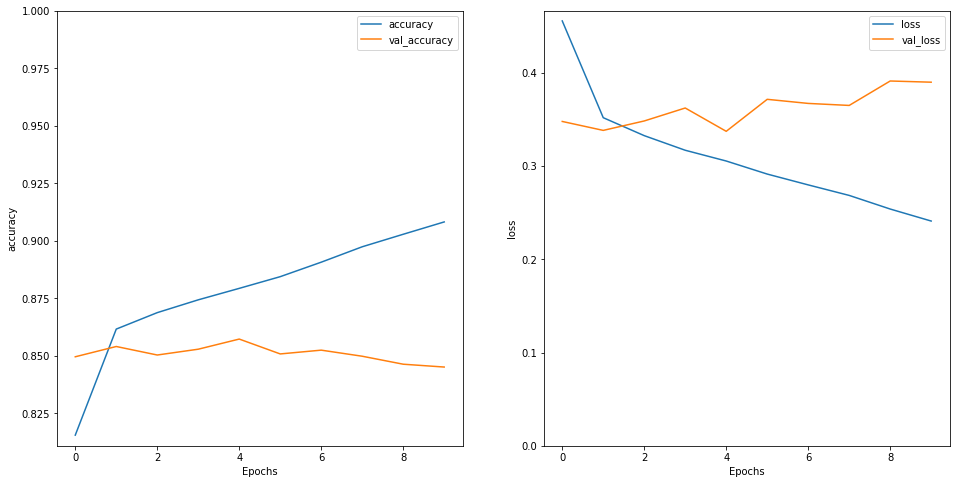

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
type(history)

keras.callbacks.History

In [ ]:
loss, accuracy, f1_score, precision, recall = model.evaluate(x_test, y_test, verbose=0)


ValueError: ignored

In [ ]:
y_pred = model.predict(x_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)


266/266 [==============================] - 32s 121ms/step


In [ ]:
print(classification_report(y_test, y_pred_bool))

ValueError: ignored

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
y_pred1 = model.predict(x_test, batch_size=64, verbose=1)
y_pred = np.argmax(y_pred1, axis=1)
print(y_pred1)
print(y_pred)

cm = confusion_matrix(y_pred, y_pred1)
cm
# Print f1, precision, and recall scores
# print(precision_score(y_test, y_pred , average="macro"))
# print(recall_score(y_test, y_pred , average="macro"))
# print(f1_score(y_test, y_pred , average="macro"))

266/266 [==============================] - 32s 121ms/step
[[4.5866829e-01 5.3862762e-01]
 [9.9985683e-01 1.4841557e-04]
 [9.9833834e-01 1.6942024e-03]
 ...
 [8.9309106e-05 9.9991590e-01]
 [9.9941766e-01 5.9455633e-04]
 [6.5619242e-01 3.4283793e-01]]
[1 0 0 ... 1 0 0]


ValueError: ignored